In [1]:
import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import statistics

EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
BATCH_SIZE = 64  # Q-learning batch size

In [5]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class Network(nn.Module):
    def __init__(self, state_space, action_space):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(state_space, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, action_space)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [3]:
class Agent():
  def __init__(self, agent_type, env, network, task, N, num_actions, learning_rate=1e-3, discount_factor=0.99):
    self.agent_type = agent_type # 0 for q learning, 1 for sarsa, 2 for expected sarsa
    self.env = env
    self.policy = network
    self.optimizer = optim.Adam(self.policy.parameters(), learning_rate)
    self.memory = ReplayMemory(10000)
    self.n_step_memory = []

    self.task = task # 0 for acrobot and 1 for pendulum
    self.discount_factor = discount_factor
    self.learning_rate = learning_rate
    self.N = N
    self.num_actions = num_actions
    self.steps_done = 0
    self.eps_threshold = 0
    super().__init__()

  """
    Return a random action or the action with the best q-values given our policy for the pendulum environment
    Possible values are in range -2 to 2, but the actions have been discretized to 16 possible values in that range
  """
  def select_action_pendulum(self, state):
    sample = random.random()
    self.eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
    self.steps_done += 1

    if sample > self.eps_threshold:
      discretized_action = int(torch.argmax(self.policy(torch.tensor(state))).numpy())
      action = (discretized_action - 8) / 4
      return discretized_action, action
    else:
      discretized_action = np.random.choice([n for n in range(self.num_actions)])
      action = (discretized_action - 8) / 4
      return discretized_action, action
  
  """
    Return a random action or the action with the best q-values given our policy for the acrobot environment
    Possible values: 0, 1, 2
  """
  def select_action_acrobot(self, state):
    sample = random.random()
    self.eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
    self.steps_done += 1

    if sample > self.eps_threshold:
      return int(self.policy(torch.tensor(state)).argmax())
    else:
      return random.randrange(3)

  """
    Take action depending on the task --> observe and store information --> update neural net 
    Return the total reward accross an episode
  """
  def train(self, state):
    total_reward = 0
    while True:
      if self.task == 0: # take an action for the acrobot environemnt
        action = self.select_action_acrobot(state)
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.select_action_acrobot(next_state)
      else: # take an action for the pendulum environemnt
        action, pendulum_action = self.select_action_pendulum(state)
        next_state, reward, done, _ = self.env.step([pendulum_action])
        next_action, _ = self.select_action_pendulum(next_state)

      self.n_step_memory.append((state, action, reward, next_state, next_action))

      # we reached the number of steps needed to update the policy
      # compute the return and store the observations in the actual replay buffer
      if len(self.n_step_memory) > self.N:
        n_step_return = sum([self.n_step_memory[i][2]*(self.learning_rate**i) for i in range(self.N)])
        total_reward += n_step_return
        n_step_state, n_step_action, _, n_step_next_state, n_step_next_action = self.n_step_memory.pop(0)
        self.memory.push((n_step_state, n_step_action, n_step_return, n_step_next_state, n_step_next_action))

      # episode is over, we empty the n_step_memory
      if done:
        while len(self.n_step_memory) > 0:
          n_step_return = sum([self.n_step_memory[i][2] * (self.learning_rate ** i) for i in range(len(self.n_step_memory))])
          n_step_state, n_step_action, _, n_step_next_state, n_step_next_action = self.n_step_memory.pop(0)
          self.memory.push((n_step_state, n_step_action, n_step_return, n_step_next_state, n_step_next_action))
        break
      
      state = next_state

      if self.agent_type == 0: self.learn_Q()
      elif self.agent_type == 1: self.learn_SARSA()
      elif self.agent_type == 2: self.learn_Expected_SARSA()

    return total_reward

  """
    Update the weights of the neural network using the Q-learning algorithm
  """
  def learn_Q(self):
    if len(self.memory) > BATCH_SIZE:
      transitions = self.memory.sample(BATCH_SIZE)
      batch_state, batch_action, batch_reward, batch_next_state, _ = zip(*transitions)

      current_q_values = self.policy(torch.tensor(batch_state)).gather(1, torch.tensor(batch_action).unsqueeze(1)) # Q(St, At)
      max_next_q_values = self.policy(torch.tensor(batch_next_state)).detach().max(1)[0] # max(Q(St+1, A))
      expected_q_values = torch.tensor(batch_reward) + (self.discount_factor ** self.N * max_next_q_values)

      loss = F.smooth_l1_loss(current_q_values, expected_q_values.view(-1, 1))
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

  """
    Update the weights of the neural network using the SARSA algorithm
  """
  def learn_SARSA(self):
    if len(self.memory) > BATCH_SIZE:
      transitions = self.memory.sample(BATCH_SIZE)
      batch_state, batch_action, batch_reward, batch_next_state, batch_next_action = zip(*transitions)

      current_q_values = self.policy(torch.tensor(batch_state)).gather(1, torch.tensor(batch_action).unsqueeze(1)) # Q(St, At)
      next_q_values = self.policy(torch.tensor(batch_next_state)).gather(1, torch.tensor(batch_next_action).unsqueeze(1)).squeeze(1) # Q(St+1, At+1)
      expected_q_values = torch.tensor(batch_reward) + (self.discount_factor ** self.N * next_q_values)

      loss = F.smooth_l1_loss(current_q_values, expected_q_values.view(-1, 1))
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

  """
    Update the weights of the neural network using the Expected SARSA algorithm
  """
  def learn_Expected_SARSA(self):
    if len(self.memory) > BATCH_SIZE:
      transitions = self.memory.sample(BATCH_SIZE)
      batch_state, batch_action, batch_reward, batch_next_state, batch_next_action = zip(*transitions)

      current_q_values = self.policy(torch.tensor(batch_state)).gather(1, torch.tensor(batch_action).unsqueeze(1)) # Q(St, At)
      all_next_q_values = self.policy(torch.tensor(batch_next_state)) # Q(St+1, A)
      max_next_q_values = self.policy(torch.tensor(batch_next_state)).detach().max(1)[0] # max(Q(St+1, A))
      greedy_actions = 0

      # get the number of actions for the next state that result in the maximum q-value possible
      # we do so because we need the probability of taking each action given the next state
      for i in range(BATCH_SIZE):
        for j in range(self.num_actions):
          if all_next_q_values[i][j] == max_next_q_values[i]:
            greedy_actions += 1

      # for each action, we get the probability of taking that action
      non_greedy_action_probability = self.eps_threshold / self.num_actions
      greedy_action_probability = ((1 - self.eps_threshold) / greedy_actions) + non_greedy_action_probability

      # multiply each action with the probability of taking it
      # take the sum of all the multiplications
      expected_q_values = []
      for i in range(BATCH_SIZE):
        if max_next_q_values[i] in all_next_q_values[i]:
          expected_q_values.append(sum(all_next_q_values[i] * greedy_action_probability)) # sum( π(a, s) * Q(St+1, a) )
        else:
          expected_q_values.append(sum(all_next_q_values[i] * non_greedy_action_probability)) # sum( π(a, s) * Q(St+1, a) )

      expected_q_values = torch.tensor(batch_reward) + (self.discount_factor ** self.N * torch.tensor(expected_q_values))

      loss = F.smooth_l1_loss(current_q_values, expected_q_values.view(-1, 1))
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

Training agents on the pendulum environment
Training agent DQN, with N = 1
Agent DQN, with N = 1 has finished training
Training agent DQN, with N = 3
Agent DQN, with N = 3 has finished training
Training agent DQN, with N = 6
Agent DQN, with N = 6 has finished training
Training agent D_SARSA, with N = 1
Agent D_SARSA, with N = 1 has finished training
Training agent D_SARSA, with N = 3
Agent D_SARSA, with N = 3 has finished training
Training agent D_SARSA, with N = 6
Agent D_SARSA, with N = 6 has finished training
Training agent D_EXP_SARSA, with N = 1
Agent D_EXP_SARSA, with N = 1 has finished training
Training agent D_EXP_SARSA, with N = 3
Agent D_EXP_SARSA, with N = 3 has finished training
Training agent D_EXP_SARSA, with N = 6
Agent D_EXP_SARSA, with N = 6 has finished training


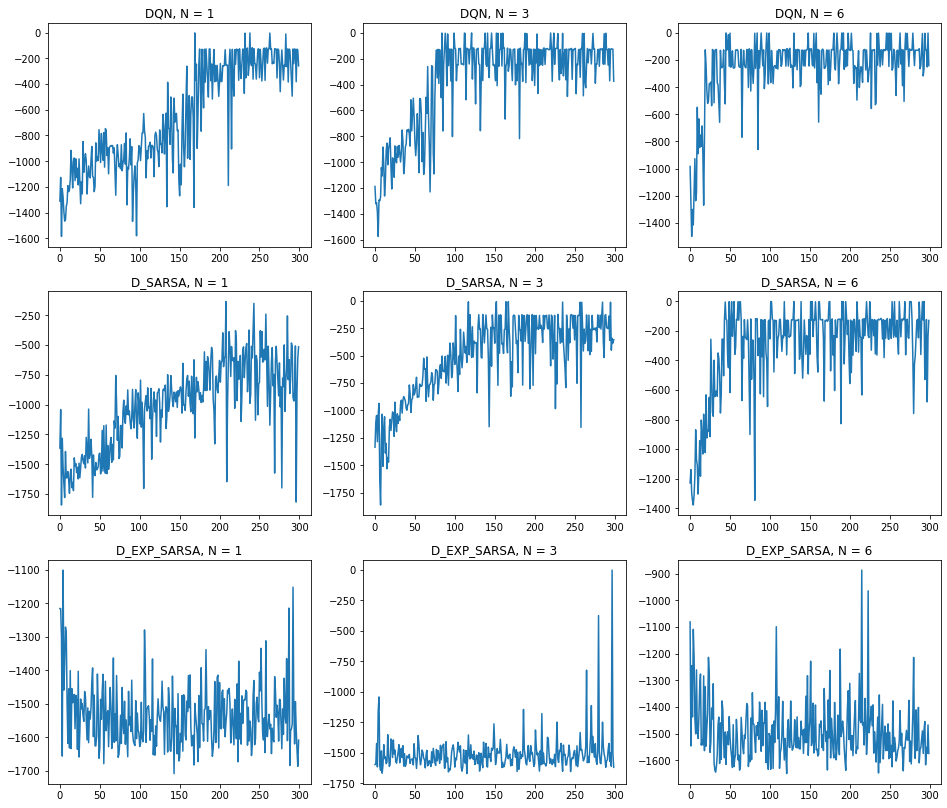

In [7]:
def train_pendulum(EPISODES):
    print("Training agents on the pendulum environment")
    env = gym.make('Pendulum-v1')
    plot_axes = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
    agents = [[0, "DQN"], [1, "D_SARSA"], [2, "D_EXP_SARSA"]]

    ln = list(range(0, EPISODES))
    figure, axis = plt.subplots(3, 3, figsize=(16, 14))

    c = 0
    def train_agent(agent, N, c):
      reward = []
      for e in range(EPISODES):
        state = env.reset()
        reward.append(agent.train(state))
      return reward
    
    for agent in agents:
      for N in [1, 3, 6]:
        print("Training agent {0}, with N = {1}".format(agent[1], N))
        rewards = train_agent(Agent(agent[0], env, Network(3, 17), task=1, N=N, num_actions=17), agent[1], c)

        axis[plot_axes[c][0], plot_axes[c][1]].plot(ln, rewards)
        axis[plot_axes[c][0], plot_axes[c][1]].set_title("{0}, N = {1}".format(agent[1], N))
        
        print("Agent {0}, with N = {1} has finished training".format(agent[1], N))
        c += 1

train_pendulum(EPISODES=300)

Training agents on the acrobot environment
Training agent DQN, with N = 1
Agent DQN, with N = 1 has finished training
Training agent DQN, with N = 3
Agent DQN, with N = 3 has finished training
Training agent DQN, with N = 6
Agent DQN, with N = 6 has finished training
Training agent D_SARSA, with N = 1
Agent D_SARSA, with N = 1 has finished training
Training agent D_SARSA, with N = 3
Agent D_SARSA, with N = 3 has finished training
Training agent D_SARSA, with N = 6
Agent D_SARSA, with N = 6 has finished training
Training agent D_EXP_SARSA, with N = 1
Agent D_EXP_SARSA, with N = 1 has finished training
Training agent D_EXP_SARSA, with N = 3


KeyboardInterrupt: ignored

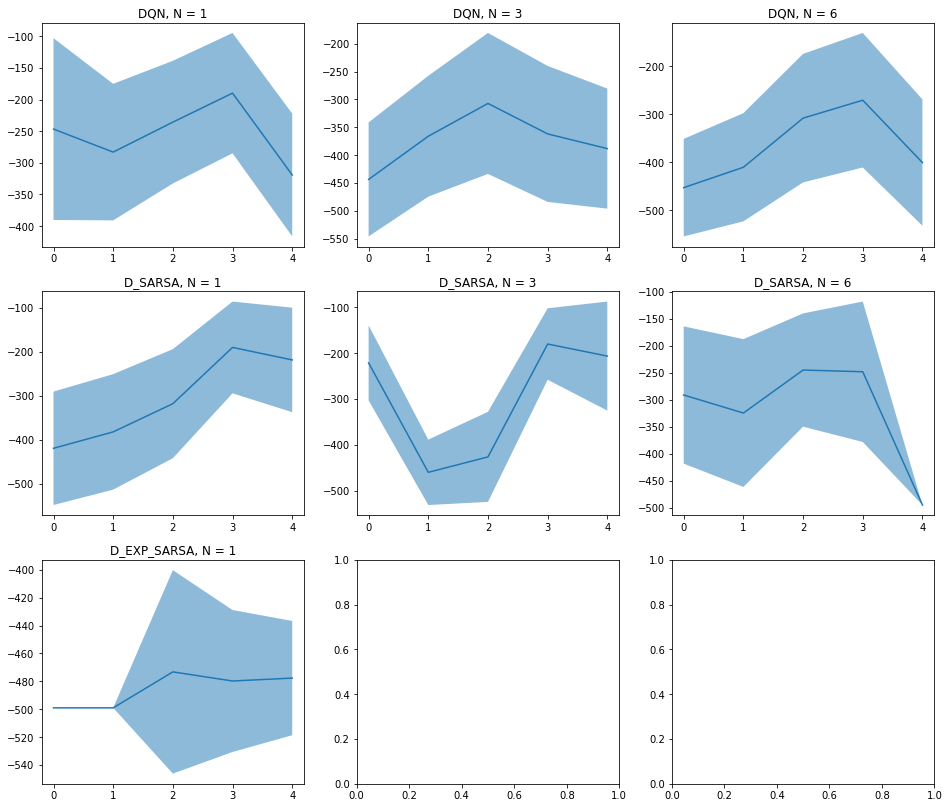

In [ ]:
def train_acrobot(EPISODES):
    print("Training agents on the acrobot environment")
    env = gym.make('Acrobot-v1')
    plot_axes = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
    agents = [[0, "DQN"], [1, "D_SARSA"], [2, "D_EXP_SARSA"]]

    ln = list(range(0, EPISODES))
    figure, axis = plt.subplots(3, 3, figsize=(16, 14))

    c = 0
    def train_agent(agent, N, c):
      reward = []
      for e in range(EPISODES):
        state = env.reset()
        reward.append(agent.train(state))
      return reward
    
    for agent in agents:
      for N in [1, 3, 6]:
        print("Training agent {0}, with N = {1}".format(agent[1], N))
        rewards = train_agent(Agent(agent[0], env, Network(6, 3), task=0, N=N, num_actions=3), agent[1], c)

        axis[plot_axes[c][0], plot_axes[c][1]].plot(ln, rewards)
        axis[plot_axes[c][0], plot_axes[c][1]].set_title("{0}, N = {1}".format(agent[1], N))
        
        print("Agent {0}, with N = {1} has finished training".format(agent[1], N))
        c += 1

train_pendulum(EPISODES=300)